In [20]:
from pathlib import Path
from pascal_voc_writer import Writer
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
import itertools

from skimage.transform import rescale, resize, downscale_local_mean

In [4]:
dataset_folder = Path("generated")
dataset_limit = 10

In [5]:
def load_bounding_boxes(bb_file):
    boxes = []
    with open(bb_file) as readable:
        for line in readable:
            parts = line.split()
            if len(parts) > 5:
                continue
            boxes.append((
                parts[0],
                int(parts[1]),
                int(parts[2]),
                int(parts[3]),
                int(parts[4])
            ))
    return boxes
image = io.imread(dataset_folder / "images" / "000003.jpg")
boxes  = load_bounding_boxes(dataset_folder / "bounding_boxes" / "000003.txt")

c:\users\anton\.virtualenvs\card-detection-djagg3og\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


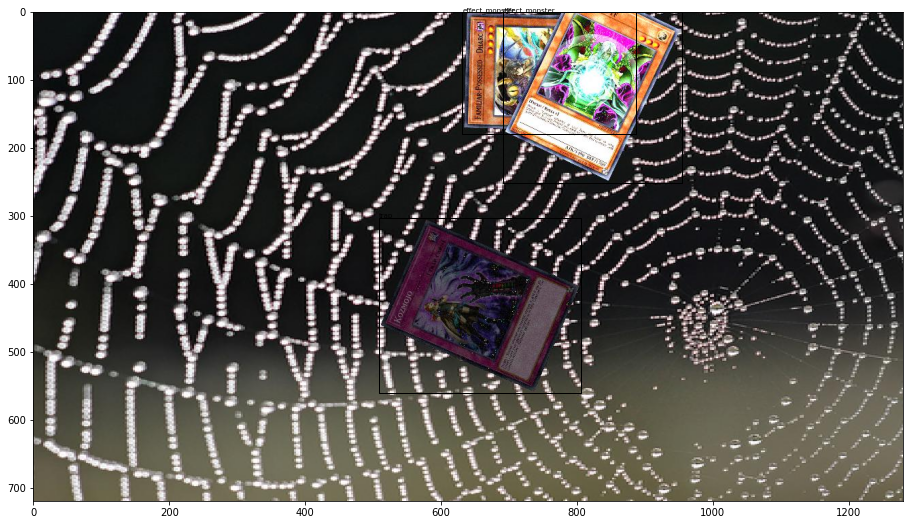

In [6]:
def show_with_boxes(image, boxes):
    fig = plt.figure(figsize=(16,9))
    ax = fig.gca()
    rects = []
    for box in boxes:
        rect = Rectangle((box[1], box[2]),box[3], box[4],facecolor='red', fill=False, alpha=1)
        ax.text(box[1], box[2], box[0], size=7)
        rects.append(rect)

    ax.imshow(image)
    pc = PatchCollection(rects, match_original=True)

    ax.add_collection(pc)
    
    fig.show()
    
show_with_boxes(image, boxes)

In [43]:
def resize_with_boxes(image, boxes, shape=(512,512)):
    new_boxes = []
    image_resized = (resize(image, shape, anti_aliasing=True) * 255).astype(np.uint8)
    
    y_ = image.shape[0]
    x_ = image.shape[1]
    
    x_scale = shape[0] / x_
    y_scale = shape[1] / y_
    
    for box in boxes:
        (origLeft, origTop, origRight, origBottom) = box[1:]

        x = int(origLeft * x_scale)
        y = int(origTop * y_scale)
        xmax = int(origRight * x_scale)
        ymax = int(origBottom * y_scale)
        
        new_boxes.append((
            box[0],
            x,
            y,
            xmax,
            ymax
        ))
    return image_resized, new_boxes


splits = {"train":{}, "test":{}, "validate":{}}

for split in splits:
    transformed_images_folder = Path(f"transformed/{split}/images")
    transformed_annotations_folder = Path(f"transformed/{split}/annotations")
    transformed_images_folder.mkdir(exist_ok=True, parents=True)
    transformed_annotations_folder.mkdir(exist_ok=True, parents=True)
    
    splits[split]["images"] = transformed_images_folder
    splits[split]["annotations"] = transformed_annotations_folder

def resize_example(input_args):
    example, segment = input_args
    example = f"{example:06}"
    image = io.imread(dataset_folder / "images" / f"{example}.jpg")
    boxes = load_bounding_boxes(dataset_folder / "bounding_boxes" / f"{example}.txt")
    
    image_path = splits[segment]["images"] / f"{example}.jpg"
    annotation_path = splits[segment]["annotations"] / f"{example}.xml"
    
    resized_image, resized_boxes = resize_with_boxes(image, boxes)
    
    writer = Writer(str(image_path), 512, 512)

    for object_class, x, y, width, height in resized_boxes:
        writer.addObject(object_class, x, y, x+width, y+height)

    io.imsave(image_path, resized_image)
    writer.save(annotation_path)

c:\users\anton\.virtualenvs\card-detection-djagg3og\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


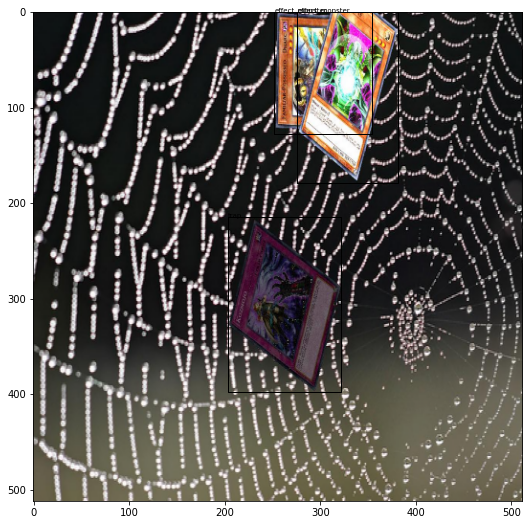

In [44]:
image_resized, resized_boxes = resize_with_boxes(image, boxes)
show_with_boxes(image_resized, resized_boxes)

In [45]:
train_examples = 7_000
test_examples = 2_000
validate_examples = 2_000

examples = itertools.chain(
    ((idx,"train") for idx in range(0, train_examples)),
    ((idx,"test") for idx in range(train_examples, train_examples + test_examples)),
    ((idx,"validate") for idx in range(train_examples + test_examples, train_examples + test_examples + validate_examples)),
)

In [46]:
import time
import os
from joblib import Parallel, delayed

t0 = time.time()

Parallel(n_jobs=12, prefer="threads")(delayed(resize_example)(args) for args in examples)

t1 = time.time()

print(t1-t0)


464.3083670139313
